In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#!pip install fastai==0.7.0
#!pip install torchtext==0.2.3
import os

os.makedirs("data\walmart",exist_ok=True)
os.makedirs(".kaggle",exist_ok=True)
!pip install kaggle
#!mkdir .kaggle

import json 
token = {"username":"hduongck","key":"983e2ab1fbb29cf2734bcbf8811d42fb"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
 
!chmod 600 /content/.kaggle/kaggle.json

!kaggle config set -n path -v{/content/data}

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting -p /content/data/walmart

#!unzip /content/data/rossmann/\*.zip -d data/rossmann

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 11, in <module>
    load_entry_point('kaggle==1.5.3', 'console_scripts', 'kaggle')()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 489, in load_entry_point
    return get_distribution(dist).load_entry_point(group, name)
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2843, in load_entry_point
    return ep.load()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2434, in load
    return self.resolve()
  File "/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py", line 2440, in resolve
    module = __import__(self.module_name, fromlist=['__name__'], level=0)
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 116, in authenticate
    self.config_file, self.config_d

In [0]:
from fastai.tabular import *

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from IPython.display import display

In [4]:

PATH ='data/walmart/'
!ls {PATH}

features.csv.zip	  stores.csv	train.csv.zip
sampleSubmission.csv.zip  test.csv.zip


In [5]:
!unzip /content/data/walmart/\*.zip -d data/walmart

Archive:  /content/data/walmart/features.csv.zip
  inflating: data/walmart/features.csv  

Archive:  /content/data/walmart/test.csv.zip
  inflating: data/walmart/test.csv   

Archive:  /content/data/walmart/train.csv.zip
  inflating: data/walmart/train.csv  

Archive:  /content/data/walmart/sampleSubmission.csv.zip
  inflating: data/walmart/sampleSubmission.csv  

4 archives were successfully processed.


In [0]:
table_names = ['train','stores','features','test']

In [0]:
tables = [pd.read_csv(f'{PATH}{fname}.csv',low_memory=True) for fname in table_names]

In [8]:
for t in tables : display(t.tail())

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


,Store,Dept,Date,IsHoliday
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False
115063,45,98,2013-07-26,False


In [0]:
train,stores,features,test = tables

In [10]:
len(train), len(test), len(features), len(stores)

(421570, 115064, 8190, 45)

Deal with missing values in boolean type

In [0]:
train.IsHoliday.fillna(False,inplace=True)
train.IsHoliday = train.IsHoliday.map({'False':False,'True':True})
train.IsHoliday = train.IsHoliday.astype(bool)

In [0]:
test.IsHoliday.fillna(False,inplace=True)
test.IsHoliday = test.IsHoliday.map({'False':False,'True':True})
test.IsHoliday = test.IsHoliday.astype(bool)

In [0]:
def join_df(left,right,left_on,right_on=None,suffix='_y'):
    if right_on is None : right_on = left_on
    return left.merge(right,how="left",left_on=left_on,right_on=right_on,
                     suffixes = ("",suffix))

deal with date column

In [14]:
add_datepart(train,'Date',drop=False)
add_datepart(features,'Date',drop=False)
add_datepart(test,'Date',drop=False)

,Store,Dept,Date,IsHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,1,2012-11-02,True,2012,11,44,2,4,307,False,False,False,False,False,False,1351814400
1,1,1,2012-11-09,True,2012,11,45,9,4,314,False,False,False,False,False,False,1352419200
2,1,1,2012-11-16,True,2012,11,46,16,4,321,False,False,False,False,False,False,1353024000
3,1,1,2012-11-23,True,2012,11,47,23,4,328,False,False,False,False,False,False,1353628800
4,1,1,2012-11-30,True,2012,11,48,30,4,335,True,False,False,False,False,False,1354233600
5,1,1,2012-12-07,True,2012,12,49,7,4,342,False,False,False,False,False,False,1354838400
6,1,1,2012-12-14,True,2012,12,50,14,4,349,False,False,False,False,False,False,1355443200
7,1,1,2012-12-21,True,2012,12,51,21,4,356,False,False,False,False,False,False,1356048000
8,1,1,2012-12-28,True,2012,12,52,28,4,363,False,False,False,False,False,False,1356652800
9,1,1,2013-01-04,True,2013,1,1,4,4,4,False,False,False,False,False,False,1357257600


Merge features to stores

In [15]:
stores = join_df(stores,features,'Store')
len(stores[stores.Type.isnull()])

0

In [16]:
stores.shape

(8190, 27)

Merge stores to train and test data

In [17]:
joined_train = join_df(train,stores,["Store","Date","IsHoliday"])
len(joined_train[joined_train.Dept.isnull()])

0

In [18]:
joined_train.shape

(421570, 42)

In [19]:
joined_test = join_df(test,stores,["Store","Date","IsHoliday"])
len(joined_test[joined_test.Dept.isnull()]), 


(0,)

In [20]:
joined_train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month',
       'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
       'Is_year_start', 'Elapsed', 'Type', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Year_y', 'Month_y', 'Week_y', 'Day_y', 'Dayofweek_y',
       'Dayofyear_y', 'Is_month_end_y', 'Is_month_start_y', 'Is_quarter_end_y',
       'Is_quarter_start_y', 'Is_year_end_y', 'Is_year_start_y', 'Elapsed_y'],
      dtype='object')

In [0]:
for df in (joined_train,joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True,axis=1)

In [22]:
joined_train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Year', 'Month',
       'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
       'Is_year_start', 'Elapsed', 'Type', 'Size', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment'],
      dtype='object')

In [23]:
joined_train.shape

(421570, 29)

Markdown :  anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

In [0]:
joined_train.loc[joined_train.Date<"2011-12-01",['MarkDown1','MarkDown2','MarkDown3','MarkDown4']]=0

In [0]:
joined_train = joined_train.set_index('Date')
joined_test= joined_test.set_index('Date')

In [26]:
train_cats(joined_train)

NameError: ignored

In [0]:
apply_cats(joined_test,joined_train)

In [0]:
joined_train.shape, joined_test.shape

#Random Forest

In [0]:
df_train,y,nas = proc_df(joined_train,"Weekly_Sales")

In [0]:
y = np.log1p(np.clip(y,0,None))

In [0]:
def split_vals(a,n) : return a[:n].copy(),a[n:].copy()

In [0]:
n_valid = len(joined_test)
n_trn = len(joined_train) - n_valid
X_train,X_valid = split_vals(df_train,n_trn)
y_train,y_valid = split_vals(y,n_trn)

In [0]:
#train[['Store','Dept','Date']]= train[['Store','Dept','Date']].astype(str)

#train['Id'] = train[['Store','Dept','Date']].apply(lambda x: '_'.join(x),axis=1)
 

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train),y_train),
           rmse(m.predict(X_valid),y_valid),
           m.score(X_train,y_train),
           m.score(X_valid,y_valid)]
    if hasattr(m,'oob_score_'): res.append(m.oob_score_)
    print(res)

In [0]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train,y_train)
print_score(m)

In [0]:
m = RandomForestRegressor(n_jobs=-1,n_estimators=40,oob_score=True)
m.fit(X_train,y_train)
print_score(m)

**We cannot use RandomForest which cannot deal with time series data as it has extrapolate issue**

# Feature importance

In [0]:
fi = rf_feat_importance(m,df_train); fi[:10]

why only Dept and Store significantly imporatant compared to others features

In [0]:
fi.plot('cols','imp',figsize=(10,6),legend=False);
plt.xticks(np.arange(len(fi),step=10),fi.cols.values);

# Run by Neural Network

In [0]:
from fastai.column_data import *

In [0]:
#joined_train.Temperature.value_counts()

In [0]:
cat_vars = ['Store', 'Dept', 'IsHoliday', 'Year', 'Month',
       'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
       'Is_year_start', 'Elapsed', 'Type', 'Size']
contin_vars = ['Fuel_Price','MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment','Temperature']

In [0]:
joined_test['Weekly_Sales']=0

In [0]:
for v in cat_vars : joined_train[v] = joined_train[v].astype('category').cat.as_ordered()

In [0]:
apply_cats(joined_test,joined_train)

In [0]:
for v in contin_vars :
    joined_train[v] = joined_train[v].fillna(0).astype('float32')
    joined_test[v]  = joined_test[v].fillna(0).astype('float32')

In [0]:
joined_train.head()

In [0]:
df,y,nas,mapper = proc_df(joined_train,'Weekly_Sales',do_scale=True)
yl=np.log1p(np.clip(y,0,None))

In [0]:
df.head()

In [0]:
df_test,_,nas,mapper=proc_df(joined_test,'Weekly_Sales',do_scale=True,mapper=mapper,na_dict=nas)

In [0]:
n_val = len(joined_test)
n_trn = len(joined_train) - n_val
val_idx =list(range(n_trn,len(joined_train)))

In [0]:
def inv_y(a) : return np.exp(a)

def exp_rmspe(y_pred,targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y= np.max(yl)
y_range = (0,max_log_y*1.2)

In [0]:
md = ColumnarModelData.from_data_frame(PATH,val_idx,df,yl.astype(np.float32),cat_flds=cat_vars,bs=128,
                                      test_df=df_test)

In [0]:
cat_sz = [(c,len(joined_train[c].cat.categories)+1) for c in cat_vars]
cat_sz

In [0]:
emb_szs = [(c,min(50,(c+1)//2)) for _,c in cat_sz]
emb_szs

In [0]:
m = md.get_learner(emb_szs,len(df.columns)-len(cat_vars),
             0.04,1,[1000,500],[0.001,0.01],
             y_range=y_range)

In [0]:
m.lr_find()

In [0]:
m.sched.plot()

In [0]:
lr = 1e-2

In [0]:
m.fit(lr,1,metrics=[exp_rmspe],cycle_len = 1)

#2019 Fastai Tabular model Library

In [28]:
joined_train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,...,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,1,1,24924.50,True,2010,2,5,5,4,36,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2010-02-12,1,1,46039.49,True,2010,2,6,12,4,43,...,151315.0,38.51,2.548,0.0,0.0,0.0,0.0,NaN,211.24217,8.106
2010-02-19,1,1,41595.55,True,2010,2,7,19,4,50,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2010-02-26,1,1,19403.54,True,2010,2,8,26,4,57,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2010-03-05,1,1,21827.90,True,2010,3,9,5,4,64,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [29]:
joined_test.head()

,Store,Dept,IsHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,...,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-02,1,1,True,2012,11,44,2,4,307,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-09,1,1,True,2012,11,45,9,4,314,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-16,1,1,True,2012,11,46,16,4,321,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-23,1,1,True,2012,11,47,23,4,328,False,...,151315.0,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
2012-11-30,1,1,True,2012,11,48,30,4,335,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
joined_train.shape,joined_test.shape

((421570, 28), (115064, 27))

In [0]:
procs =[FillMissing,Categorify,Normalize]

In [0]:
valid_idx = range(len(joined_train)-100000,len(joined_train))

In [0]:
dep_var='Weekly_Sales'
cat_names = ['Store', 'Dept', 'IsHoliday', 'Year', 'Month',
       'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end',
       'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
       'Is_year_start', 'Elapsed', 'Type', 'Size']

In [0]:
path = 'data/walmart/'

In [0]:
data = TabularDataBunch.from_df(path,joined_train,dep_var,valid_idx=valid_idx,
                               procs=procs,cat_names=cat_names)

In [39]:
data.show_batch()

Store,Dept,IsHoliday,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,Type,Size,CPI_na,MarkDown4_na,MarkDown3_na,MarkDown5_na,Unemployment_na,MarkDown2_na,MarkDown1_na,Fuel_Price_na,Temperature_na,CPI,MarkDown4,MarkDown3,MarkDown5,Unemployment,MarkDown2,MarkDown1,Fuel_Price,Temperature,target
7,9,True,2012,2,6,10,4,41,False,False,False,False,False,False,1328832000,B,70713.0,False,False,False,False,False,False,False,False,False,1.3717,4.5050,-0.0265,7.1893,0.8415,0.5905,8.2741,-0.7923,-5.2372,14384.42
22,9,True,2011,8,34,26,4,238,False,False,False,False,False,False,1314316800,#na#,#na#,True,False,False,True,True,False,False,True,True,0.0702,-0.0921,-0.1048,-0.0406,-0.0115,-0.0815,-0.1213,-0.0329,-0.0314,35857.56
7,52,True,2011,6,22,3,4,154,False,False,False,False,False,False,1307059200,#na#,#na#,True,False,False,True,True,False,False,True,True,0.0702,-0.0921,-0.1048,-0.0406,-0.0115,-0.0815,-0.1213,-0.0329,-0.0314,917.79
20,28,True,2011,11,47,25,4,329,False,False,False,False,False,False,1322179200,A,203742.0,False,False,False,False,False,False,False,False,False,2.7060,-0.0921,-0.1048,-1.7446,-1.6249,-0.0815,-0.1213,2.7666,-0.1095,964.54
25,3,True,2010,7,28,16,4,197,False,False,False,False,False,False,1279238400,#na#,#na#,True,False,False,True,True,False,False,True,True,0.0702,-0.0921,-0.1048,-0.0406,-0.0115,-0.0815,-0.1213,-0.0329,-0.0314,9650.23


- Not sure why it’s occurring but it appears your targs are a FloatTensor instead of a LongTensor. Try creating your own accuracy function by copying the fastai accuracy function and changing the following line by adding a .long() and supplying that as your accuracy method.

`targs = targs.view(-1).long()`

- targs stands for target arguments It’s the values that are the truth values (the Y values) that are being compared to your model’s predicted values. The accuracy metric above takes two arguments the input (predicted values) and targs (target values) and calculates the accuracy. The error encountered above was due to the fact that the input had Long values but targs had Float values. All my suggestion did was to have them convert the Float values to Long values so they could be properly compared by the == operator.


In [0]:
# redefine the accuracy as we face the error the targs(target) is float type while default in lib is Long type
def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1).long() # turn target value int Long type
    return (input==targs).float().mean()

In [0]:
learn = tabular_learner(data,layers=[200,100],metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


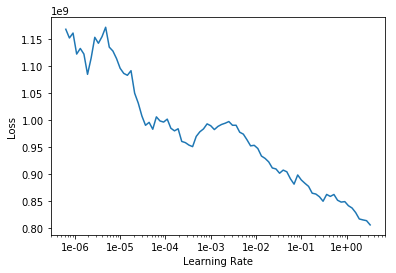

In [50]:
learn.lr_find()
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(4,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,77221296.000000,316048896.000000,0.002080,02:32
1,81952040.000000,348389696.000000,0.002080,02:33


KeyboardInterrupt: ignored

In [0]:
??accuracy